In [ ]:
import os
os.chdir('../')

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import torch
import torch.nn as nn

import torch.nn.functional as F
from torch import optim
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

import numpy as np

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from collections import OrderedDict

from lateral_connections import LateralModel, VggModel
from lateral_connections import VggWithLCL
from lateral_connections import MNISTCDataset
from lateral_connections.loaders import get_loaders, load_mnistc
from lateral_connections.layers import LaterallyConnectedLayer, LaterallyConnectedLayer2, LaterallyConnectedLayer3
from lateral_connections.torch_utils import *
from lateral_connections.dataset import TinyDataset, TinyDatasetEasy

import wandb
import datetime

DO_WANDB = False

# lehl@2022-06-09: 
config = {
    'num_classes': 10,
    'learning_rate': 3e-4,
    'num_multiplex': 2,
    'batch_size': 4,
    'num_epochs': 20,
    'lcl_alpha': 0.5,
    'lcl_eta': 0.036, # Empirically evaluated :eta to switch ~30 from-to connections (0.0360: 40, 0.0160: 30, 0.0030: 10, 0.0015: 5)
    'lcl_theta': 0.2,
    'lcl_iota': 0.2,
    'lcl_distance': 2,
    'conv_size': 10,
    'use_scaling': False,
}

base_name = datetime.datetime.now().strftime('%Y-%m-%d_%H%M%S')
wandb_run_name = base_name
wandb_group_name = 'TinyLCL_Debug'

wandb.login(key='efd0a05b7bd26ed445bf073625a373b845fc9385')
wandb.init(
    project='MT_LateralConnections',
    entity='lehl',
    #group=wandb_group_name,
    group='debug',
    name=wandb_run_name,
    config=config,
    mode='disabled',
)

def plot_kernels(model, plot_scale=3):
    num_kernels = model.lcl.K.shape[0]

    fig, axs = plt.subplots(num_kernels, num_kernels, figsize=(plot_scale*num_kernels, plot_scale*num_kernels))

    kernel_data = model.lcl.K.cpu()

    for x in range(num_kernels):
        for y in range(num_kernels):
            axs[x,y].imshow(kernel_data[x,y,...])
            
    plt.show()
    plt.close()

wandb: Currently logged in as: lehl (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/claude/.netrc


In [3]:
def small_transform():
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5), std=(0.5))
    ])

dataset = MNIST('images/mnist/', train=True, transform=small_transform(), download=True)

train_size = 50000
eval_size = len(dataset) - train_size
train_dataset, eval_dataset = torch.utils.data.random_split(dataset, [train_size, eval_size], generator=torch.Generator().manual_seed(42))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=1)
val_loader = torch.utils.data.DataLoader(eval_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=1)

corrupt_dataset = load_mnistc('line')
corrupt_loader = torch.utils.data.DataLoader(corrupt_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=1)


tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

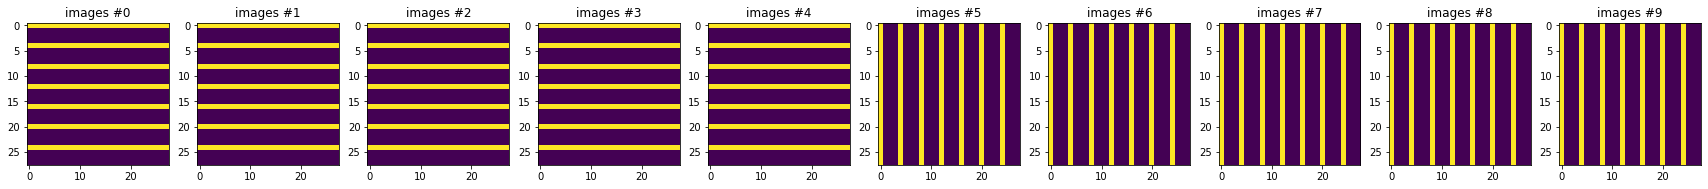

In [4]:
ds = TinyDatasetEasy()
ds_loader = torch.utils.data.DataLoader(ds, batch_size=config['batch_size'], shuffle=True, num_workers=1)

images = ds.data
labels = ds.labels

fig, axs = plt.subplots(1,10, figsize=(30,3))
for i in range(10):
    axs[i].imshow(images[i][0,...], vmin=0, vmax=1)
    axs[i].set_title(f"images #{i}")

labels

In [5]:
class LateralDebugNetwork(nn.Module):
    def __init__(self, config):
        super(LateralDebugNetwork, self).__init__()
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using {self.device} for PyTorch.")
        
        self.config = config
        
        self.conv = nn.Conv2d(in_channels=1, out_channels=config['conv_size'], bias=True, padding=1, kernel_size=(3,3))
        self.act1 = nn.ReLU()
        self.pool = nn.AdaptiveMaxPool2d((14,14))
        self.act_lcl = nn.Tanh()
        self.lcl = LaterallyConnectedLayer3(self.config['num_multiplex'], config['conv_size'], 14, 14,
                              d=self.config['lcl_distance'],
                              prd=self.config['lcl_distance'],
                              disabled=False,
                              alpha=self.config['lcl_alpha'],
                              beta=(1 / ((50000/2) / self.config['batch_size'])),
                              eta=self.config['lcl_eta'],
                              theta=self.config['lcl_theta'],
                              iota=self.config['lcl_iota'],
                              use_scaling=config['use_scaling'],
                              random_k_change=False,
                              random_multiplex_selection=False,
                              gradient_learn_k=False)
        
        self.fc1 = nn.Linear(in_features=config['conv_size']*14*14, out_features=100)
        self.act2 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=100, out_features=self.config['num_classes'])
        
        self.loss_fn = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=self.config['learning_rate'])
        
    def forward(self, x):
        x = self.conv(x)
        x = self.act1(x)
        x = self.pool(x)
        
        x = self.act_lcl(x)
        x = self.lcl(x)
        x = torch.flatten(x, 1)
        
        x = self.fc1(x)
        x = self.act2(x)
        x = self.fc2(x)
        return x
    
    def train_with_loader(self, loader, epochs=10, iterations_p_epoch=500):
        iter_loader = iter(loader)
        
        for e in tqdm(range(epochs)):
            correct = 0
            total = 0
            total_loss = 0
            
            for it in tqdm(range(iterations_p_epoch)):
                self.train()

                try:
                    images, labels = next(iter_loader)
                except StopIteration:
                    iter_loader = iter(loader)
                    images, labels = next(iter_loader)

                images = images.to(self.device)
                labels = labels.to(self.device)

                outputs = self(images)
                loss = self.loss_fn(outputs, labels)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                _, preds = torch.max(outputs, 1)

                correct += (preds == labels).sum().item()
                total += labels.size(0)
                total_loss += (loss.item() / labels.size(0))
                    
            print({ 'epoch': e, 'train_acc': correct / total, 'train_loss': total_loss / iterations_p_epoch })
            
            fig, axs = plt.subplots(1, self.config['conv_size'], figsize=(3*self.config['conv_size'], 3))
            for k in range(self.config['conv_size']):
                axs[k].imshow(model.conv.weight.data.cpu().numpy()[k,0,...], vmin=-1, vmax=1)
            plt.show()

Using cuda for PyTorch.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

{'epoch': 0, 'train_acc': 0.9976019184652278, 'train_loss': 0.027670770176813676}


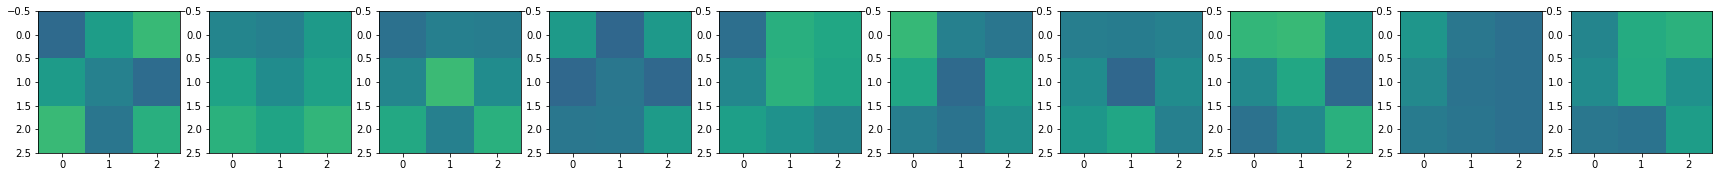

In [6]:
model = LateralDebugNetwork(config)
model = model.to(model.device)

model.lcl.disable()
model.train_with_loader(ds_loader, epochs=1)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

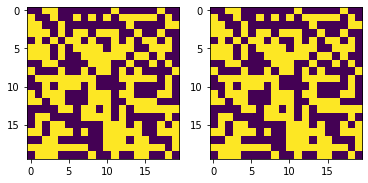

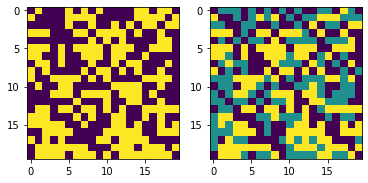

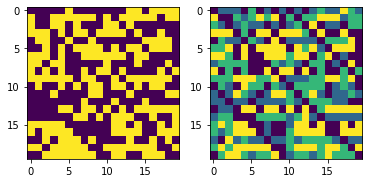

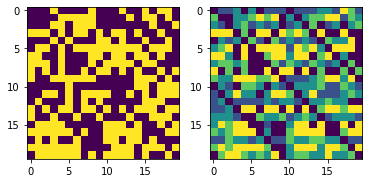

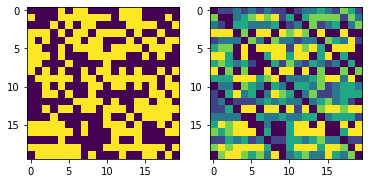

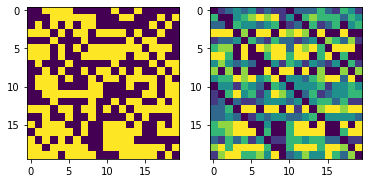

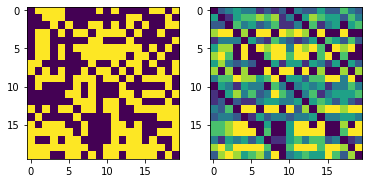

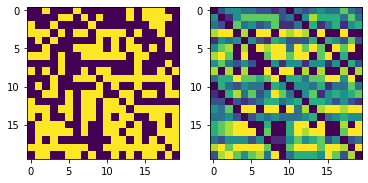

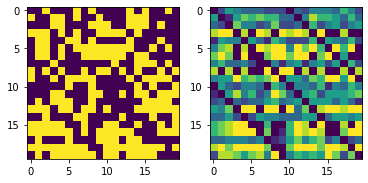

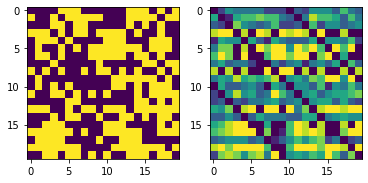

{'epoch': 0, 'train_acc': 0.1, 'train_loss': 0.9038459822535515}


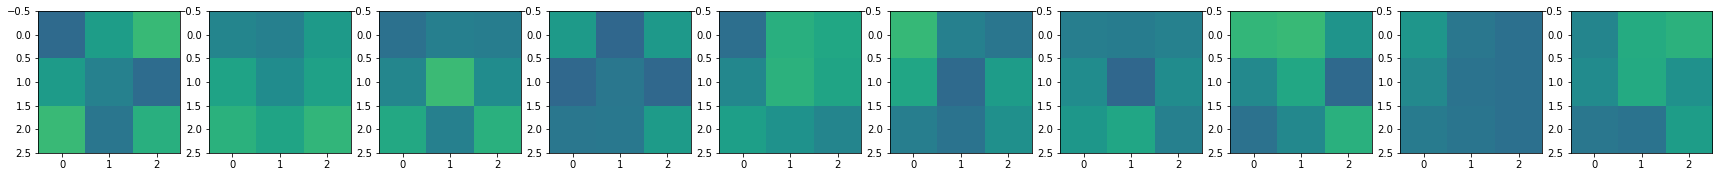

In [7]:
for i, layer in enumerate(model.children()):
    if i >= 4:
        continue
    for param in layer.parameters():
        param.requires_grad = False
        
model.lcl.enable()
model.lcl.eta -= model.lcl.eta
model.lcl.eta += 0.036

model.lcl.alpha -= model.lcl.alpha
model.lcl.alpha += 1e-2
model.train_with_loader(train_loader, epochs=1)

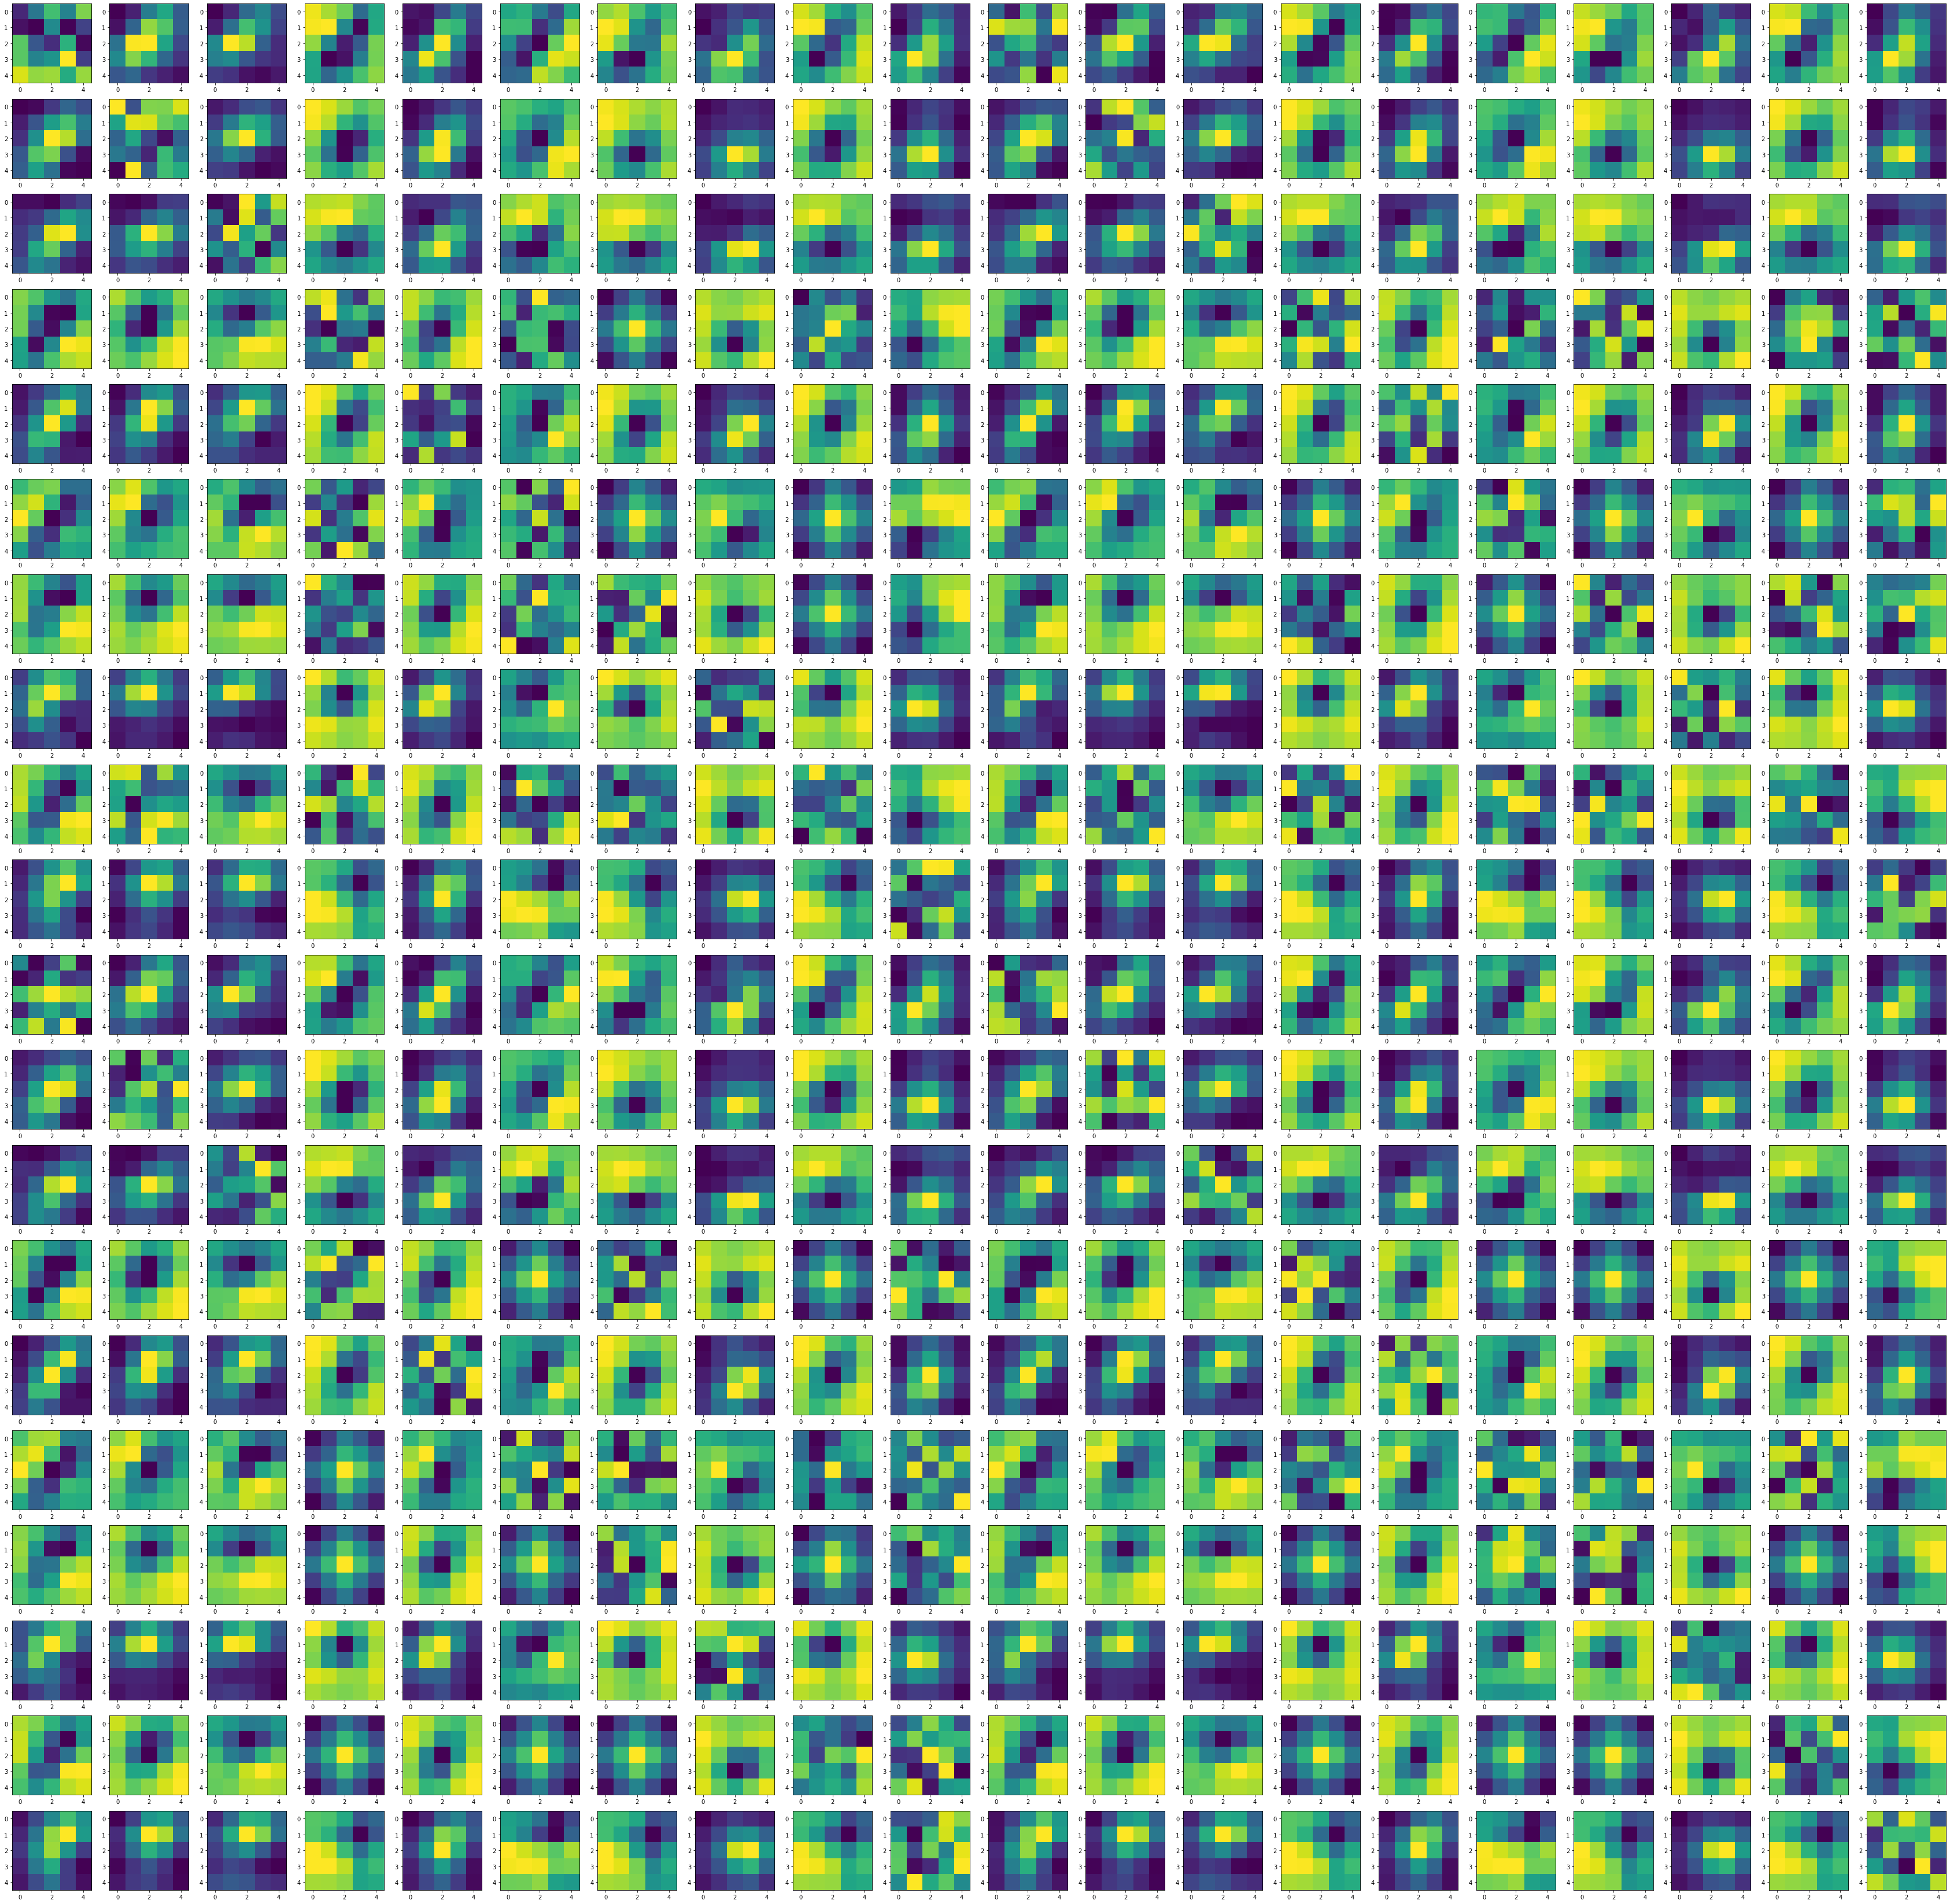

In [8]:
plot_kernels(model)

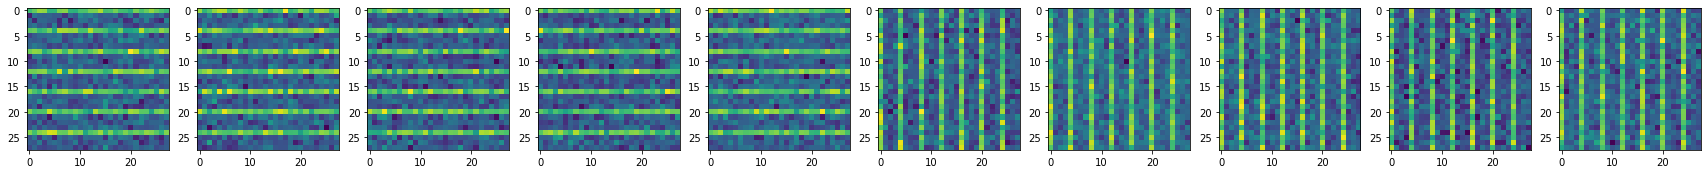

In [9]:
noisy_images = images + 0.2*torch.normal(torch.zeros(images.shape), torch.ones(images.shape))

fig, axs = plt.subplots(1, noisy_images.shape[0], figsize=(3*noisy_images.shape[0], 3))
for xi in range(noisy_images.shape[0]):
    axs[xi].imshow(noisy_images[xi,0,...])
plt.show()

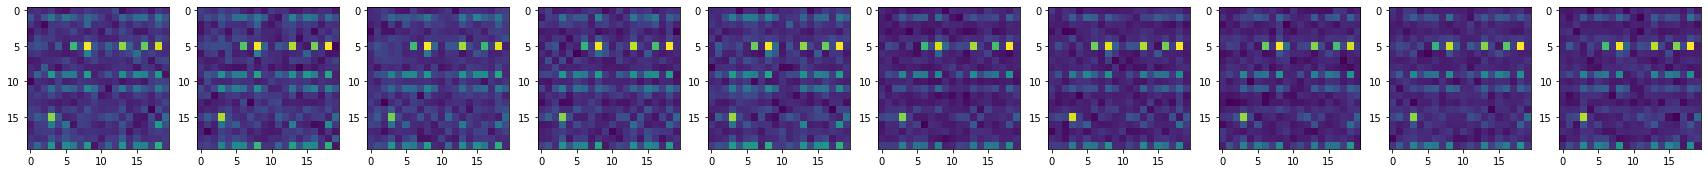

In [10]:
x = model.conv(noisy_images.to(model.device))
x = model.act1(x)
x = model.pool(x)

y = model.act_lcl(x)
x = model.lcl(y)
x = x.cpu()
y = y.cpu()

data = model.lcl.after_noise.cpu()
fig, axs = plt.subplots(1, data.shape[0], figsize=(3*data.shape[0], 3))

for xi in range(data.shape[0]):
    axs[xi].imshow(data[xi])
    
plt.show()

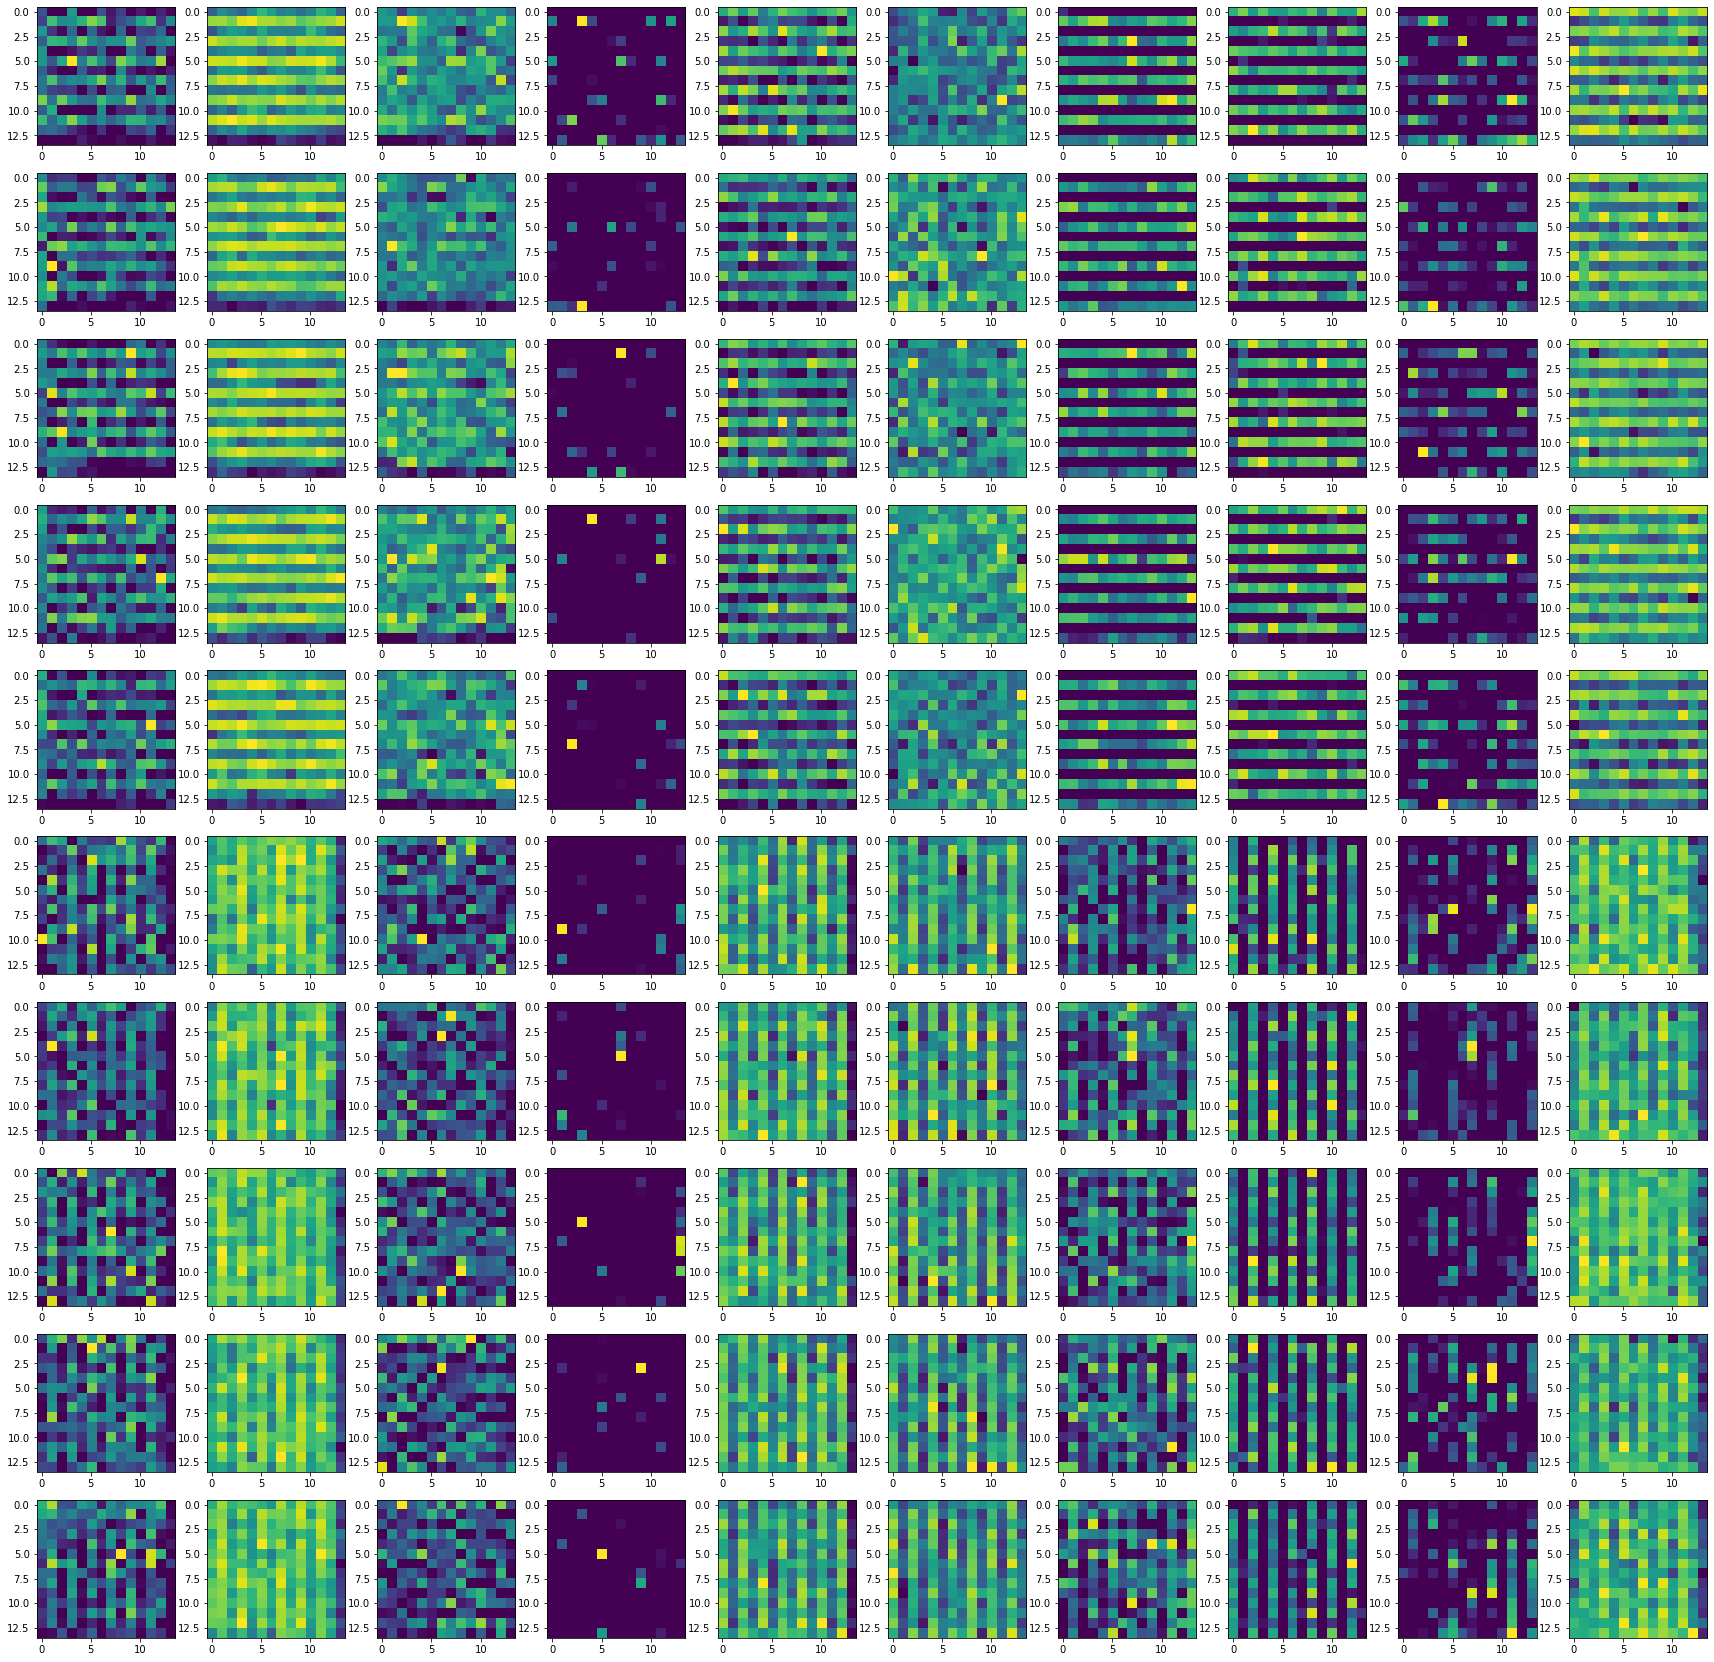

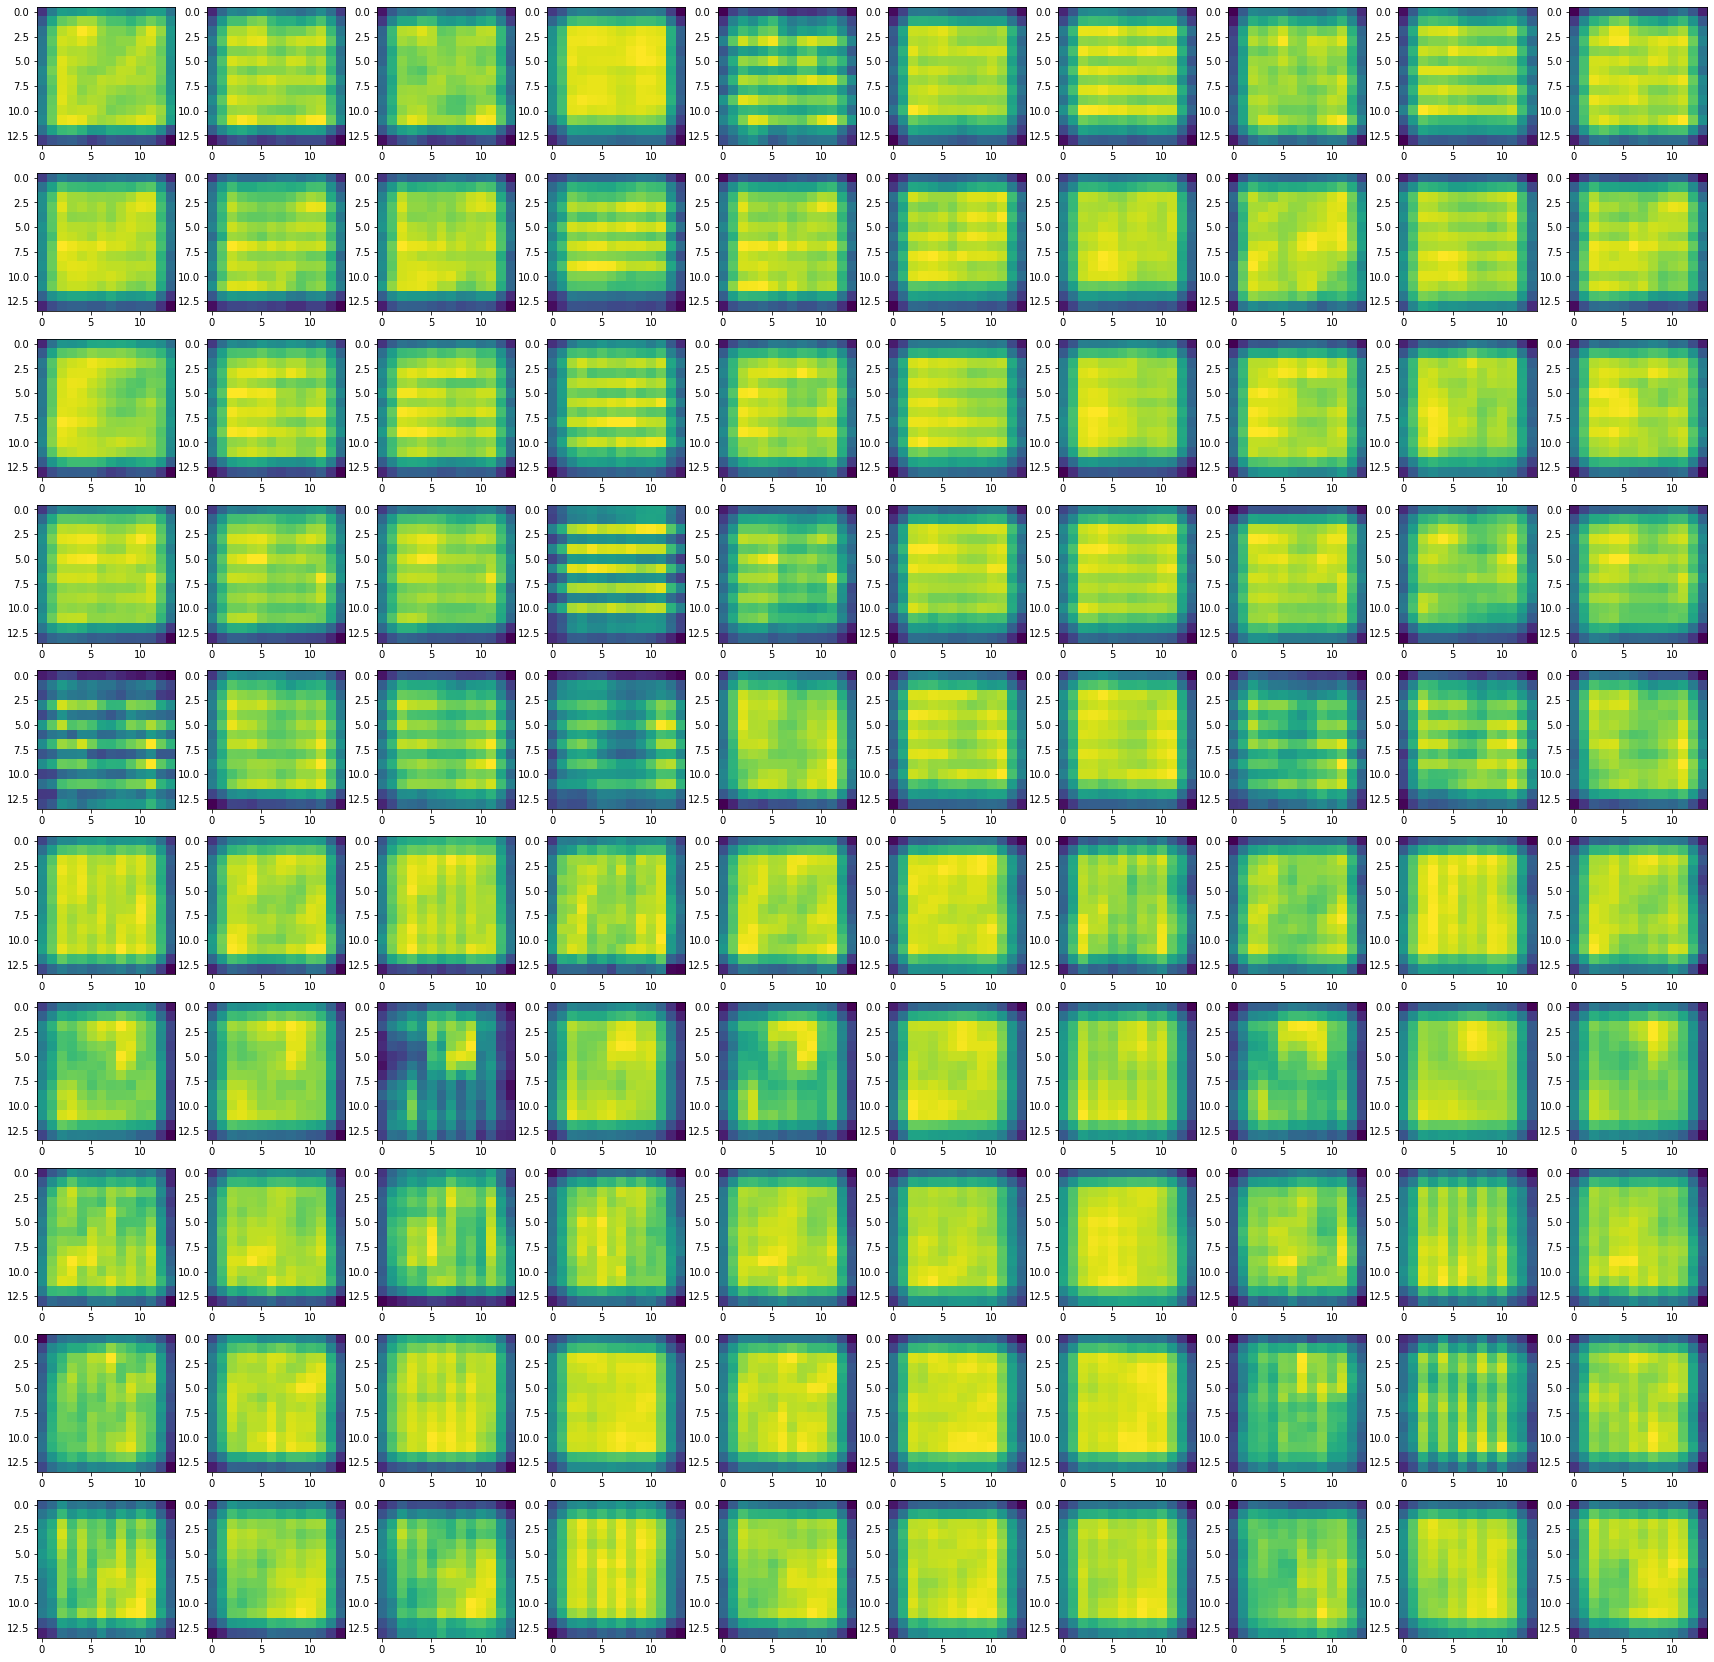

In [11]:
fig, axs = plt.subplots(y.shape[0], y.shape[1], figsize=(3*y.shape[1], 3*y.shape[1]))
for xi in range(y.shape[0]):
    for yi in range(y.shape[1]):
        axs[xi, yi].imshow(y[xi, yi])

plt.show()

fig, axs = plt.subplots(x.shape[0], x.shape[1], figsize=(3*x.shape[1], 3*x.shape[1]))
for xi in range(x.shape[0]):
    for yi in range(x.shape[1]):
        axs[xi, yi].imshow(x[xi, yi])

plt.show()